In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

In [21]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [18]:
n_epochs = 3
batch_size_train = 1
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [19]:
trainloader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

testloader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')

In [20]:
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


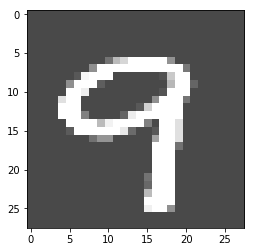

    9


In [21]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(1)))

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
#        self.conv1 = nn.Conv2d(3, 6, 5)
#        self.pool = nn.MaxPool2d(2, 2)
#        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(3 * 32 * 32, 10)
        self.fc2 = nn.Linear(10, 10)
#        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
#        x = x.view(-1, 3 * 32 * 32)
        x = F.relu(self.fc2(self.fc1(x)))
#        x = self.pool(F.relu(self.conv1(x)))
#        x = self.pool(F.relu(self.conv2(x)))
#        x = F.relu(self.fc1(x))
#        x = F.relu(self.fc2(x))
#        x = self.fc3(x)
        return x


net = Net()

In [22]:
class BasicRNN(nn.Module):
    def __init__(self, n_inputs, n_neurons, Wx_in, Wy_in, Y_hat_in):
        super(BasicRNN, self).__init__()
        
        self.Wx = Wx_in # n_inputs X n_neurons
        self.Wy = Wy_in # n_neurons X n_neurons
        self.Y_hat = Y_hat_in # 1 x n_neurons
        
        self.Y0 = torch.randn(1, n_neurons) # 1 X n_neurons
        
        self.eta = 0.01 # learning rate
        self.ceiling = 100 # maximum activity
        self.input_size = n_inputs
        self.neuron_size = n_neurons
    
    def forward(self, X1):
#        self.Y0 = torch.ReLU(torch.mm(X0, self.Wx) + self.b) # batch_size X n_neurons
        
        self.Y0 = torch.mm(X1, self.Wx) - torch.mm(self.Y0, self.Wy) # batch_size X n_neurons, highest activity 100
        self.Y0[self.Y0 < 0] = 0
        return self.Y0
    
    def updateY(self, Y_in):
        self.Y0 = self.Y0 + self.eta*(Y_in - self.Y0)

    def updateY_hat(self, outputs):
        self.Y_hat += torch.mul(outputs, outputs)
#        self.Y_hat = torch.clamp(self.Y0, -10**10, 10**10)
        self.Y_hat[torch.isnan(self.Y_hat)] = 0
        
    def updateWy(self, outputs):
        D = torch.diag(torch.diag(self.Wy))
        self.Wy += torch.div(torch.mm(outputs.T, outputs) - torch.mul(self.Wy, torch.mm(torch.ones((self.neuron_size, 1)), torch.mul(outputs, outputs))), torch.mm(torch.ones((self.neuron_size, 1)), self.Y_hat) + 10**-30)
        self.Wy = self.Wy - torch.diag(torch.diag(self.Wy)) + D
        self.Wy[torch.isnan(self.Wy)] = 0
#        self.Wy = torch.clamp(self.Wy, -10**10, 10**10)

    def updateWx(self, outputs, inputs):
        self.Wx += torch.div(torch.mm(inputs.T, outputs) - torch.mul(self.Wx, torch.mm(torch.ones((self.input_size,1)), torch.mul(outputs, outputs))), torch.mm(torch.ones((self.input_size, 1)), self.Y_hat) + 10**-30)
        self.Wx[torch.isnan(self.Wx)] = 0
#        self.Wx = torch.clamp(self.Wx, -10**10, 10**10)

In [44]:
N_INPUT = 1*28*28 # number of features in input
N_NEURONS = 400 # number of units in layer

N_INPUT_2 = 400 # number of features in input
N_NEURONS_2 = 10 # number of units in layer

#X0_batch = torch.randn(1, N_INPUT) #t=0 => 4 X 3

#X1_batch = torch.tensor([[9,8,7,6,5], [0,0,0,0,0], 
#                         [6,5,4,3,2], [3,2,1,0,9]],
#                        dtype = torch.float) #t=1 => 4 X 3

In [45]:
# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [46]:
# Model instance
model = BasicRNN(N_INPUT, N_NEURONS, torch.randn(N_INPUT, N_NEURONS), torch.randn(N_NEURONS, N_NEURONS), torch.randn(1, N_NEURONS))
criterion = torch.nn.MSELoss()

In [84]:
dataiter = iter(trainloader)
inputs, labels = dataiter.next()

In [89]:
model.updateY_hat(outputs)
model.updateWx(outputs, inputs.view(-1, 3 * 32 * 32))
model.updateWy(outputs)

In [90]:
outputs = model.forward(inputs.flatten().view(-1, 3*32*32))
print(model.Y0)
print(outputs)
loss = criterion(outputs, model.Y0)
print(loss)
model.updateY(outputs)

tensor([[0.0000e+00, 0.0000e+00, 4.2458e+01, 0.0000e+00, 2.0064e+03, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.3320e-02, 2.3510e-02,
         0.0000e+00, 1.1724e+02, 0.0000e+00, 6.8054e+01, 1.2884e-02, 0.0000e+00,
         0.0000e+00, 3.1196e+03, 0.0000e+00, 3.9518e-02, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 5.6536e+00, 0.0000e+00, 0.0000e+00, 1.0439e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 3.4159e-02, 0.0000e+00, 2.4043e+04, 1.3675e-02,
         0.0000e+00, 0.0000e+00, 3.5682e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 1.5606e-02, 5.4868e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.2593e+04, 0.0000e+00,
         9.4821e+03, 1.1347e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 3.2866e+04, 1.7902e+01, 2.3425e-02,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 1.5150e

In [91]:
i = 0
while(loss > 10**-5 and i < 10**5):
    outputs = model.forward(inputs.flatten().view(-1, 3*32*32))
    loss = criterion(outputs, model.Y0)
    model.updateY(outputs)
    i += 1
    if i%20000 == 19999:
        print(i+1, "loss:", loss)

In [92]:
print(outputs)
print(loss)

tensor([[0.0000e+00, 0.0000e+00, 4.2458e+01, 0.0000e+00, 2.0064e+03, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.3320e-02, 2.3510e-02,
         0.0000e+00, 1.1724e+02, 0.0000e+00, 6.8054e+01, 1.2884e-02, 0.0000e+00,
         0.0000e+00, 3.1196e+03, 0.0000e+00, 3.9518e-02, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 5.6536e+00, 0.0000e+00, 0.0000e+00, 1.0439e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 3.4159e-02, 0.0000e+00, 2.4043e+04, 1.3675e-02,
         0.0000e+00, 0.0000e+00, 3.5682e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 1.5606e-02, 5.4868e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.2593e+04, 0.0000e+00,
         9.4821e+03, 1.1347e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 3.2866e+04, 1.7902e+01, 2.3425e-02,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 1.5150e

In [83]:
print(outputs)
print(loss)

tensor([[     0.0000,      0.0000,      0.0000,      0.0000,      0.0000,
              0.0000,      0.0000,      0.0000,      0.0000,      0.0000,
          74689.5391,  34386.5664,      0.0000,      0.0000,  79609.4453,
              0.0000,  72953.7188,      0.0000,      0.0000,      0.0000,
              0.0000,  21809.1562,      0.0000,      0.0000,      0.0000,
              0.0000,      0.0000,      0.0000,      0.0000,      0.0000,
              0.0000,      0.0000,  23667.5312,      0.0000,      0.0000,
          59126.1602,      0.0000,      0.0000,      0.0000,      0.0000,
              0.0000,      0.0000,      0.0000,  50561.1562, 147375.4375,
              0.0000,      0.0000,      0.0000,      0.0000,      0.0000,
              0.0000,      0.0000,      0.0000,      0.0000,      0.0000,
          71240.9844,      0.0000,      0.0000,      0.0000,      0.0000,
              0.0000,      0.0000,      0.0000,      0.0000,      0.0000,
          34513.1758,      0.0000,    

In [6]:
criterion = nn.MSELoss()
optimizer_1 = optim.SGD(net.fc1.parameters(), lr=0.001, momentum=0.9)
optimizer_2 = optim.SGD(net.fc2.parameters(), lr=0.001, momentum=0.9)

In [63]:
model = BasicRNN(N_INPUT, N_NEURONS, torch.randn(N_INPUT, N_NEURONS), torch.ones(N_NEURONS, N_NEURONS)*1000, torch.randn(1, N_NEURONS))
model_2 = BasicRNN(N_INPUT_2, N_NEURONS_2, torch.randn(N_INPUT_2, N_NEURONS_2), torch.ones(N_NEURONS_2, N_NEURONS_2)*1000, torch.randn(1, N_NEURONS_2))
criterion = torch.nn.MSELoss()
criterion_check = torch.nn.MSELoss()

In [64]:
output_compare = torch.zeros(10, 10)

In [ ]:
for epoch in range(3):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        model = BasicRNN(N_INPUT, N_NEURONS, model.Wx, model.Wy, model.Y_hat)
        model_2 = BasicRNN(N_INPUT_2, N_NEURONS_2, model_2.Wx, model_2.Wy, model_2.Y_hat)

        # forward + backward + optimize
        outputs = model.forward(inputs.flatten().view(-1, 1*28*28))
        loss = criterion(outputs, model.Y0)
        model.updateY(outputs)
        
        j = 0
        while(loss > 10**-5 and j < 10**5):
            outputs = model.forward(inputs.flatten().view(-1, 1*28*28))
            loss = criterion(outputs, model.Y0)
            model.updateY(outputs)
            j += 1
#        print(i, "loss:", loss)
        
        model.updateY_hat(outputs)
        model.updateWx(outputs, inputs.view(-1, 1 * 28 * 28))
        model.updateWy(outputs)        

        # forward + backward + optimize
        outputs_2 = model_2.forward(outputs)
        loss_2 = criterion(outputs_2, model_2.Y0)
        model_2.updateY(outputs_2)
        
        j = 0
        while(loss_2 > 10**-5 and j < 10**5):
            outputs_2 = model_2.forward(outputs)
            loss_2 = criterion(outputs_2, model_2.Y0)
            model_2.updateY(outputs_2)
            j += 1
#        print(i, "loss:", loss)
        
        model_2.updateY_hat(outputs_2)
        model_2.updateWx(outputs_2, outputs)
        model_2.updateWy(outputs_2)        

        
        # print statistics
        loss_check = criterion_check(outputs_2, output_compare[labels])
        running_loss += loss_check
        output_compare[labels] = outputs_2
        if i % 10000 == 9999:    # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10000))
            running_loss = 0.0

print('Finished Training')

[1, 10000] loss: 49189232.000
[1, 20000] loss: 2775188.000
[1, 30000] loss: 2792443.250
[1, 40000] loss: 2809801.000


In [35]:
PATH = './cifar_net.pth'
torch.save(model.state_dict(), PATH)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


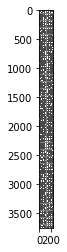

GroundTruth:      3


In [36]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(1)))

In [39]:
net = model

In [40]:
outputs = net(images)

RuntimeError: matrices expected, got 4D, 2D tensors at C:\w\1\s\tmp_conda_3.7_055457\conda\conda-bld\pytorch_1565416617654\work\aten\src\TH/generic/THTensorMath.cpp:747

In [41]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(1)))

IndexError: tuple index out of range

In [42]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

RuntimeError: matrices expected, got 4D, 2D tensors at C:\w\1\s\tmp_conda_3.7_055457\conda\conda-bld\pytorch_1565416617654\work\aten\src\TH/generic/THTensorMath.cpp:747

In [43]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(1):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

RuntimeError: matrices expected, got 4D, 2D tensors at C:\w\1\s\tmp_conda_3.7_055457\conda\conda-bld\pytorch_1565416617654\work\aten\src\TH/generic/THTensorMath.cpp:747

In [40]:
torch.mm(inputs.view(-1, 3 * 32 * 32).T, outputs).shape

torch.Size([3072, 10])

In [61]:
predicted == labels

tensor([False])